# install yfinance

In [ ]:
# https://pypi.org/project/yfinance/

!pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf

msft = yf.Ticker("AAPL")

# get stock info
msft.info

# get historical market data
hist = msft.history(period="1y")


# 定義V0

因為事後視窗為3倍，因此將V0定義為累積交易量的1/4。

In [ ]:
V_Total = hist["Volume"].sum()
V0 = V_Total/4

V0

5761767175.0

In [ ]:
print(hist["Volume"][0])

117467900


# 找出最大價差的金額與發生的時間點

Δpn = max{Sn – Sk, Sn – Sk+1, . . ., Sn – Sn–1}



```
找出最大價差（價差由大到小排序後的最大值）是負的，代表我股價處於一直下跌的情況
dp< x代表的含義就是，我要從價格下降幅度最大的罕見事件買進，並進行事後分析
```





In [ ]:
import pandas as pd


In [ ]:
l_total_event = len(hist) # 所有事件的長度
day_index = hist.index # 撈出日期

max_dp = [] # 最大價差(等同論文公式中的Q集合)
max_day = [] # 最大價差的天數
max_data_n = [] # 最大價差的日期(n)
max_data_k = [] # 最大價差的日期(k)

for n in range(1,l_total_event):
  V_sum = 0 
  dp = [] # 價差的集合
  dp_day = [] # 價差的天數的集合
  Sn = hist["Close"][n] # 後項的價格
  
  for k in range(n):
    V_sum += hist["Volume"][k] # 計算累積交易量
    if (V_sum<V0) :
      Sk = hist["Close"][k] # 前項的價格
      dp.append(Sn-Sk)
      dp_day.append([n,k])
  
  dic1 = {
      "價差":dp, "發生的天數[n,k]":dp_day # n:後項的日期； k:前項的日期
  }
  
  df1 = pd.DataFrame(dic1)
  sort_df1 = df1.sort_values(by="價差", ascending=False)
  max_dp.append(sort_df1.iloc[0,0])
  max_day.append(sort_df1.iloc[0,1])
  max_data_n.append(day_index[max_day[n-1][0]])
  max_data_k.append(day_index[max_day[n-1][1]])


dic2 = {
      "最大價差":max_dp, "最大價差發生的天數[n,k]":max_day, "最大價差發生的日期[n]":max_data_n, "最大價差發生的日期[k]":max_data_k,  # n:後項的日期； k:前項的日期
  }
Q_df = pd.DataFrame(dic2)

Q_df


,最大價差,"最大價差發生的天數[n,k]",最大價差發生的日期[n],最大價差發生的日期[k]
0,0.387741,"[1, 0]",2021-11-23 00:00:00-05:00,2021-11-22 00:00:00-05:00
1,0.914688,"[2, 0]",2021-11-24 00:00:00-05:00,2021-11-22 00:00:00-05:00
2,-4.185730,"[3, 0]",2021-11-26 00:00:00-05:00,2021-11-22 00:00:00-05:00
3,3.410233,"[4, 3]",2021-11-29 00:00:00-05:00,2021-11-26 00:00:00-05:00
4,8.441025,"[5, 3]",2021-11-30 00:00:00-05:00,2021-11-26 00:00:00-05:00
...,...,...,...,...
246,-5.865158,"[247, 3]",2022-11-15 00:00:00-05:00,2021-11-26 00:00:00-05:00
247,-7.115158,"[248, 3]",2022-11-16 00:00:00-05:00,2021-11-26 00:00:00-05:00
248,-5.185150,"[249, 3]",2022-11-17 00:00:00-05:00,2021-11-26 00:00:00-05:00
249,-4.615158,"[250, 3]",2022-11-18 00:00:00-05:00,2021-11-26 00:00:00-05:00


# 找出罕見事件 → 𝑄𝜒+ (χ) = {x : prob ( Δp < x ) < α or prob (Δp < x ) < 1 – α}



```
設alpha=0.05。
論文提及須找出一個x，使得prob(max_dp < x)時發生的機率<= alpha

這裡使用max_dp由小至大做排序，取前5%(alpha=0.05)的資料筆數，當作我的罕見事件

```




In [ ]:
alpha = 0.05

l = len(Q_df)
a = int(l * alpha)

print(a)

12


In [ ]:
Q_df1 = Q_df.sort_values(by="最大價差", ascending=True)
Q_df2 = Q_df1.iloc[:12,:].reset_index() # 取前5%(alpha=0.05)的資料筆數，當作我的罕見事件
Q_df2

,index,最大價差,"最大價差發生的天數[n,k]",最大價差發生的日期[n],最大價差發生的日期[k]
0,141,-26.240662,"[142, 3]",2022-06-16 00:00:00-04:00,2021-11-26 00:00:00-05:00
1,142,-24.745224,"[143, 3]",2022-06-17 00:00:00-04:00,2021-11-26 00:00:00-05:00
2,138,-24.426193,"[139, 3]",2022-06-13 00:00:00-04:00,2021-11-26 00:00:00-05:00
3,139,-23.548874,"[140, 3]",2022-06-14 00:00:00-04:00,2021-11-26 00:00:00-05:00
4,242,-21.035156,"[243, 3]",2022-11-09 00:00:00-05:00,2021-11-26 00:00:00-05:00
5,144,-20.966736,"[145, 3]",2022-06-22 00:00:00-04:00,2021-11-26 00:00:00-05:00
6,140,-20.886993,"[141, 3]",2022-06-15 00:00:00-04:00,2021-11-26 00:00:00-05:00
7,143,-20.448318,"[144, 3]",2022-06-21 00:00:00-04:00,2021-11-26 00:00:00-05:00
8,150,-19.600906,"[151, 3]",2022-06-30 00:00:00-04:00,2021-11-26 00:00:00-05:00
9,137,-19.192154,"[138, 3]",2022-06-10 00:00:00-04:00,2021-11-26 00:00:00-05:00


# 分析事後視窗，並印出報酬率和機率的表格與圖表

```
依據罕見事件發生的日期(共12筆)去畫圖

x軸為事後視窗大小(1, 2 ,3 倍)
Y軸為報酬率和機率


```



In [ ]:
# 新增欄位

Q_df2.insert(5,column="Vae在1倍V0時，有利價格的機率",value=0)
Q_df2.insert(6,column="Vae在2倍V0時，有利價格的機率",value=0)
Q_df2.insert(7,column="Vae在3倍V0時，有利價格的機率",value=0)
Q_df2.insert(8,column="Vae在1倍V0時的報酬率",value=0)
Q_df2.insert(9,column="Vae在2倍V0時的報酬率",value=0)
Q_df2.insert(10,column="Vae在3倍V0時的報酬率",value=0)
Q_df2

,index,最大價差,"最大價差發生的天數[n,k]",最大價差發生的日期[n],最大價差發生的日期[k],Vae在1倍V0時，有利價格的機率,Vae在2倍V0時，有利價格的機率,Vae在3倍V0時，有利價格的機率,Vae在1倍V0時的報酬率,Vae在2倍V0時的報酬率,Vae在3倍V0時的報酬率
0,141,-26.240662,"[142, 3]",2022-06-16 00:00:00-04:00,2021-11-26 00:00:00-05:00,0,0,0,0,0,0
1,142,-24.745224,"[143, 3]",2022-06-17 00:00:00-04:00,2021-11-26 00:00:00-05:00,0,0,0,0,0,0
2,138,-24.426193,"[139, 3]",2022-06-13 00:00:00-04:00,2021-11-26 00:00:00-05:00,0,0,0,0,0,0
3,139,-23.548874,"[140, 3]",2022-06-14 00:00:00-04:00,2021-11-26 00:00:00-05:00,0,0,0,0,0,0
4,242,-21.035156,"[243, 3]",2022-11-09 00:00:00-05:00,2021-11-26 00:00:00-05:00,0,0,0,0,0,0
5,144,-20.966736,"[145, 3]",2022-06-22 00:00:00-04:00,2021-11-26 00:00:00-05:00,0,0,0,0,0,0
6,140,-20.886993,"[141, 3]",2022-06-15 00:00:00-04:00,2021-11-26 00:00:00-05:00,0,0,0,0,0,0
7,143,-20.448318,"[144, 3]",2022-06-21 00:00:00-04:00,2021-11-26 00:00:00-05:00,0,0,0,0,0,0
8,150,-19.600906,"[151, 3]",2022-06-30 00:00:00-04:00,2021-11-26 00:00:00-05:00,0,0,0,0,0,0
9,137,-19.192154,"[138, 3]",2022-06-10 00:00:00-04:00,2021-11-26 00:00:00-05:00,0,0,0,0,0,0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

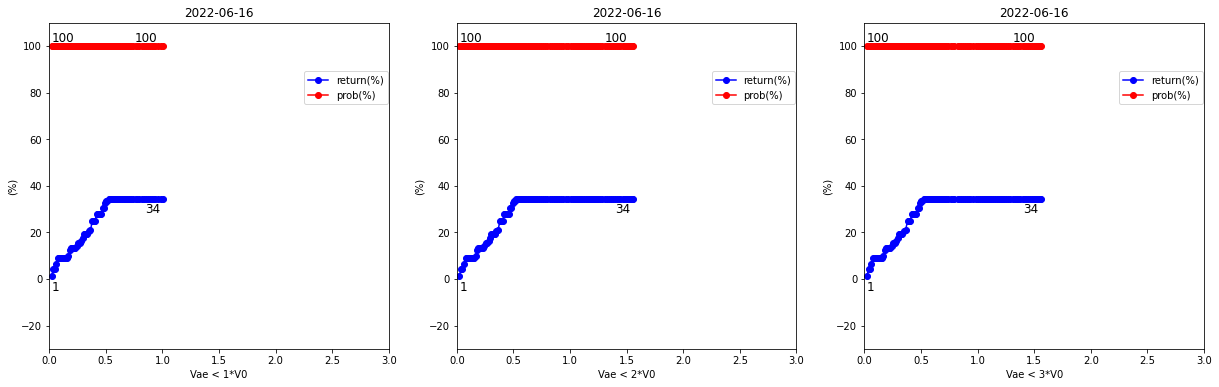

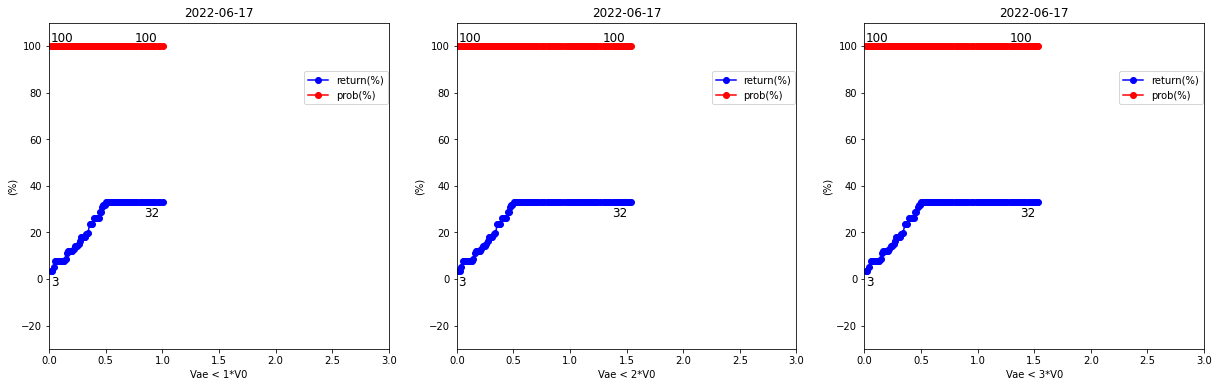

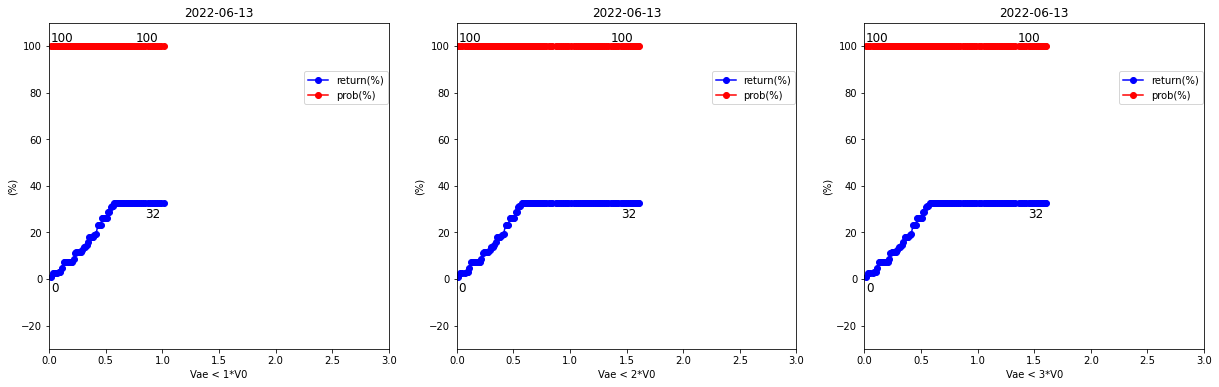

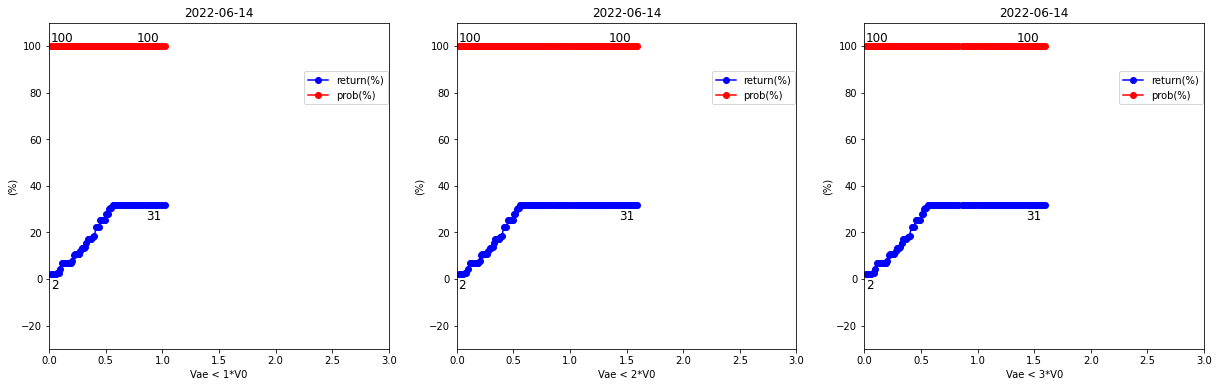

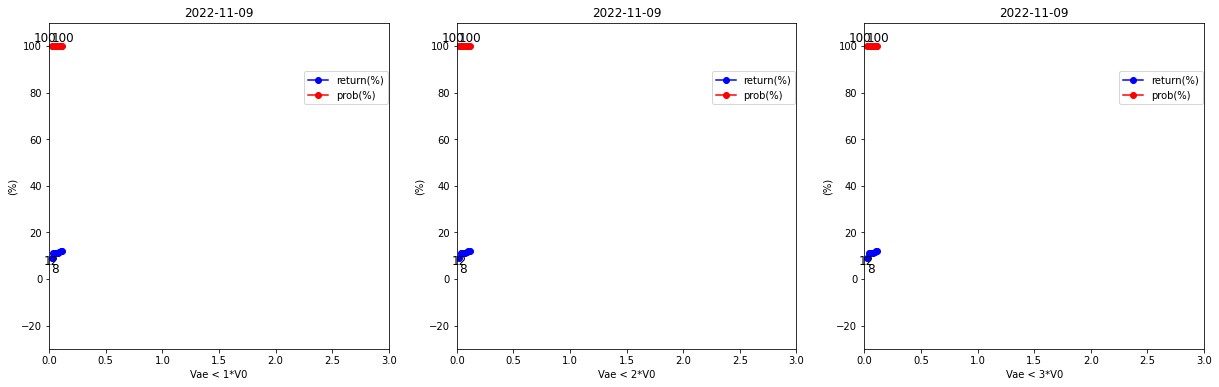

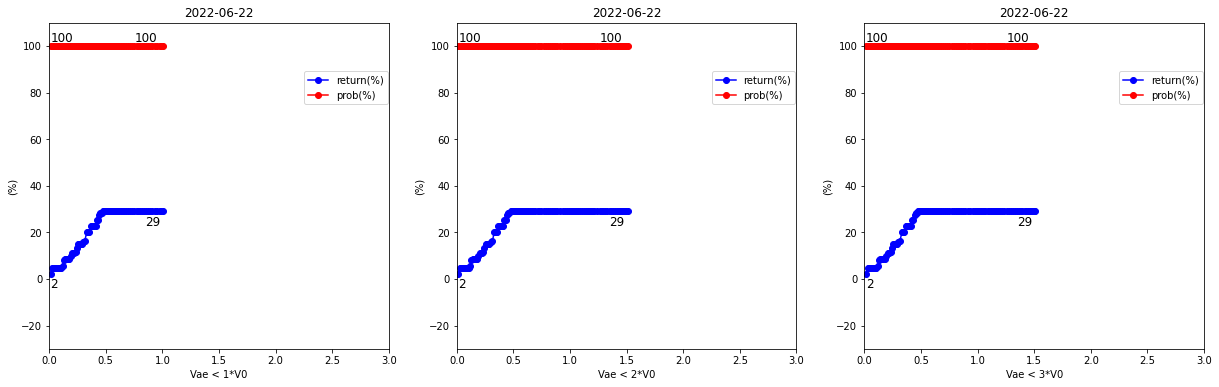

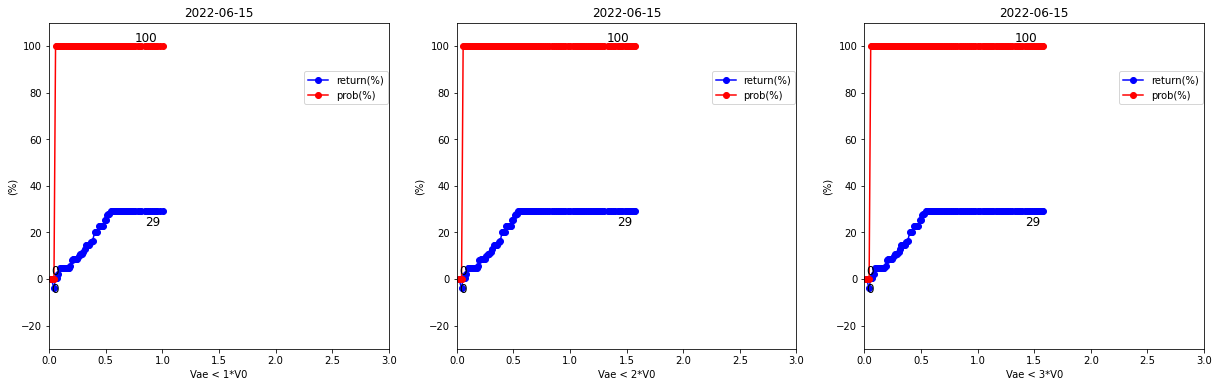

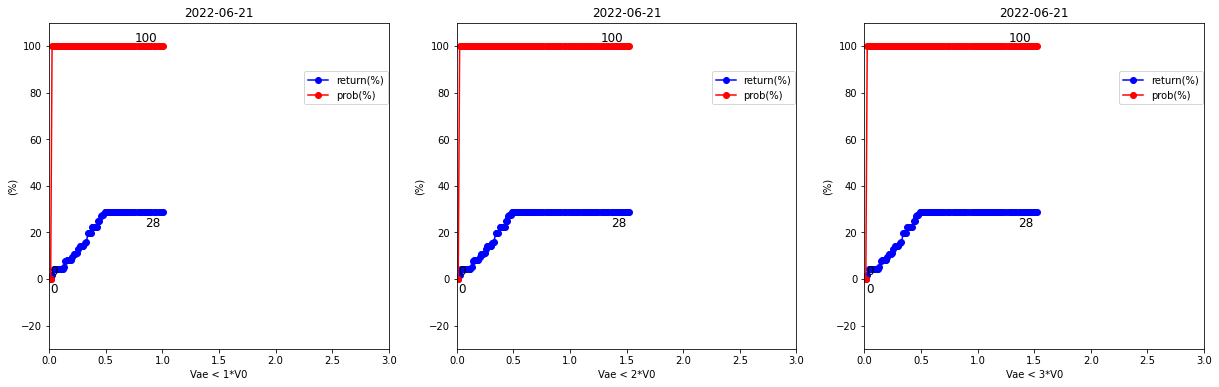

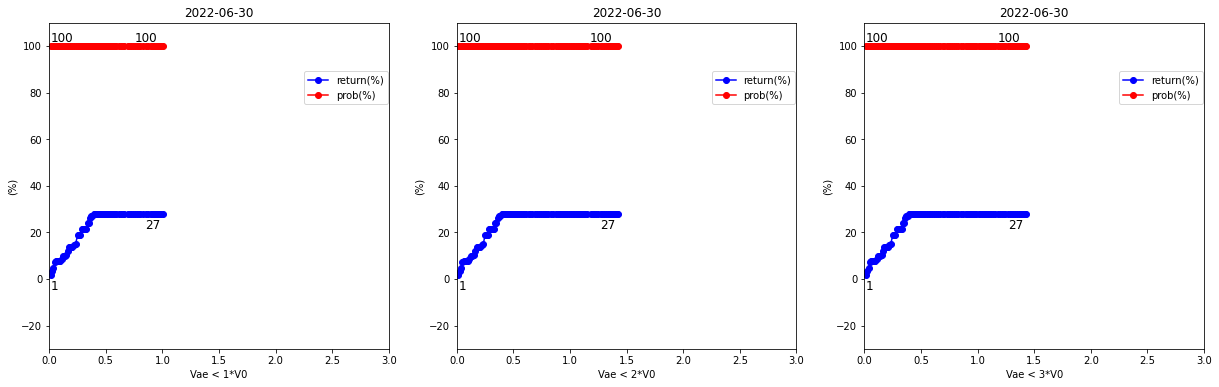

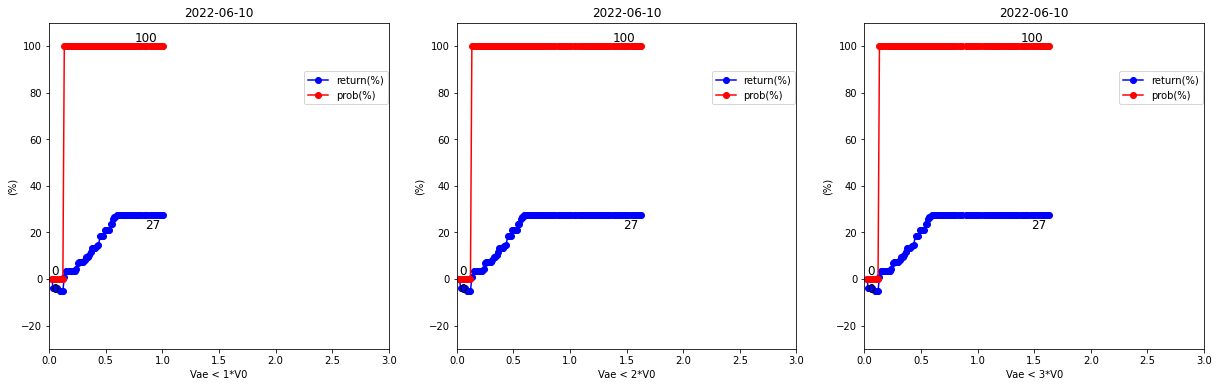

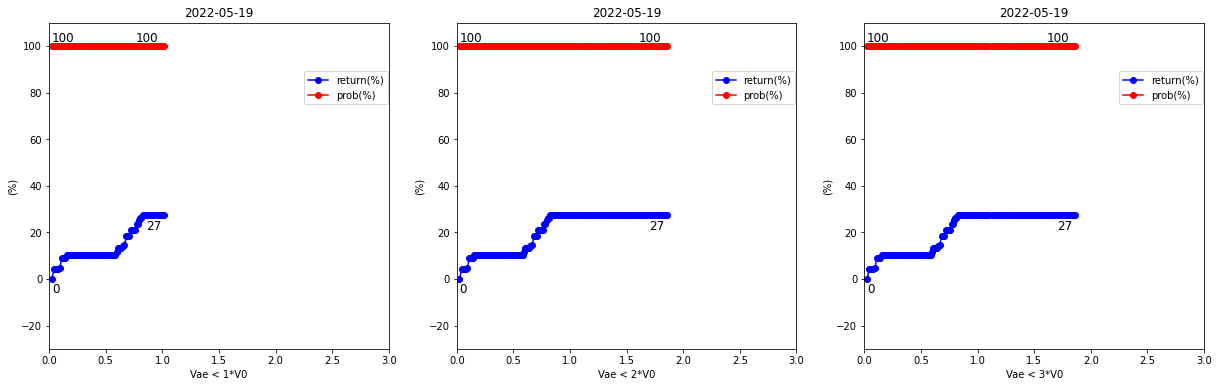

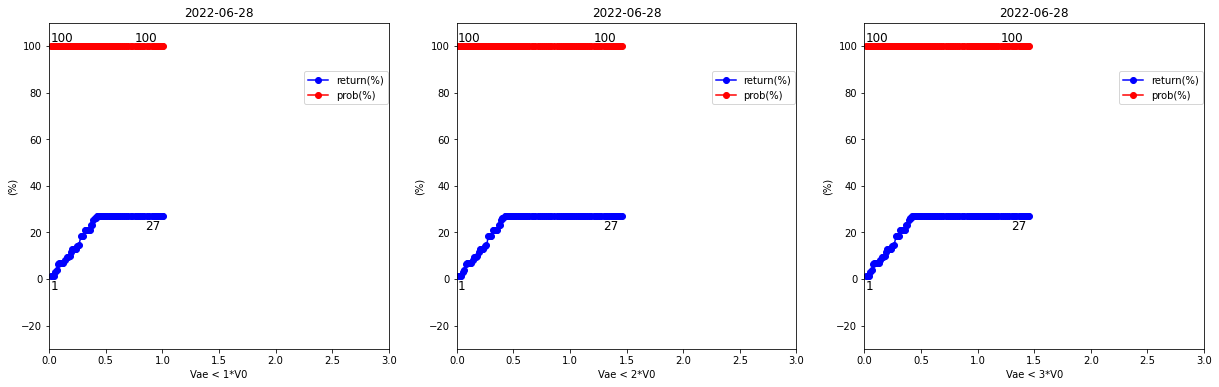

In [ ]:
for n in range(len(Q_df2)):
  happen = Q_df2["最大價差發生的天數[n,k]"][n][0] # 罕見事件發生的當天
  today_v = hist["Volume"][happen] # 罕見事件買進當天的交易量
  today_price = hist["Close"][happen] # 罕見事件買進當天的價格
  plt.figure(figsize= (28,6))

  for time in range(1,4): # 分析三倍
    Vae = 0 
    Vae_list = [] # 累積交易量的list
    judge_list = [] # 是否發生有利價格的機率，1是發生有利價格，0則是沒有發生
    favorable_price_list = [] # 有利價格的集合
    best_favorable_price = 0 # 最有利的價差
    worst_favorable_price = 0 # 最差的價差
    pass_day = 1 # 經過的天數

    while Vae < time*V0: # 當我的Vae < time倍的V0時
      next_happen = happen + pass_day
      if next_happen == len(hist):
        break
      next_v = hist["Volume"][next_happen] # 罕見事件幾天後的交易量
      next_price = hist["Close"][next_happen] # 罕見事件幾天後的價格

      Vae += next_v # 更新我的累積交易量為Vae
      Vae_list.append(Vae)
      

      favorable_price = next_price - today_price # 找出有利價格(favorable price)的價差
      pass_day += 1 


      if favorable_price > 0:
        judge_list.append(1) # 發生有利價差情況，新增1
        if favorable_price > best_favorable_price:
          favorable_price_list.append(favorable_price)
          best_favorable_price = favorable_price
        else:
          favorable_price_list.append(best_favorable_price) # 保留最有利的價差報酬
      else: 
        if best_favorable_price > 0:
          judge_list.append(1) # 發生有利價差情況，新增1
          favorable_price_list.append(best_favorable_price) # 保留最有利的價差報酬
        else:
          judge_list.append(0) # 發生不利價差情況，新增0
          if favorable_price < worst_favorable_price:
            favorable_price_list.append(worst_favorable_price)
            worst_favorable_price = favorable_price
          else:
            favorable_price_list.append(worst_favorable_price)
    

      # 以上使用定義2中的兩個交易規則
      # - 如果在事後窗口中出現有利的價格變動，我們可以使用可能的最佳報酬率平倉。
      # - 如果在事後窗口內沒有發生有利的價格變動，我們會使用窗口內可能的最差報酬率來平倉。
    
    Q_df2.iloc[n,time+4] = judge_list[-1] # 將Vae=1倍V0，2倍V0，3倍V0各別發生有利的機率放入表格中
    Q_df2.iloc[n,time+7] = favorable_price_list[-1]/(0.01*today_price) # 將Vae=1倍V0，2倍V0，3倍V0各別的報酬率放入表格中
 
    y = np.array(favorable_price_list) # 最好的價差
    x = np.array(Vae_list) # 累積交易量的事後視窗

    rare_date_after = str(Q_df2.iloc[n,3]).split()[0] # 切割出rare_date_after 罕見事件發生的當天的日期


    plt.subplot(1,4,time) # 繪製多張圖
    
    # 預期報酬率(%)圖
    plt.plot(x/V0, y/(0.01*today_price), 'bo-',label="return(%)")
    for i in range(len(x)):
        if i == 0:
            plt.text(x[i]/V0, (y[i]/today_price)*100-6, int((y[i]/today_price*100)), fontsize = 12)
            # 在每一筆資料，列印出相對應的的數值
        elif i == (len(x)-1):
            plt.text(x[i]/V0-0.16, y[i]/today_price*100-6, int((y[i]/today_price*100)), fontsize = 12)
            # 在每一筆資料，列印出相對應的的數值
        else:
            pass    
    
    # 有利價格變動的機率(%)圖
    judge_array = np.array(judge_list)
    plt.plot((x/V0), judge_array*100, 'ro-',label="prob(%)")
    for i in range(len(x)):
        if i == 0:
            plt.text(x[i]/V0, judge_array[i]*100+2, (judge_array[i]*100), fontsize = 12)
            # 在每一筆資料，列印出相對應的的數值
        elif i == (len(x)-1): # 尾
            plt.text(x[i]/V0-0.25, judge_array[i]*100+2, (judge_array[i]*100), fontsize = 12)
            # 在每一筆資料，列印出相對應的的數值
            pass
    
    plt.legend(loc = (0.75,0.75))
    plt.title("%s" % rare_date_after)
    plt.xlim(0,3) # 設定x軸的上下限
    plt.xlabel("Vae < %d*V0" % time)
    plt.ylabel("(%)")
    plt.ylim(-30,110) # 設定y軸的上下限
  plt.show()

# 因為 plt.text 只能針對當下去填寫資料內容，所以我才要跑回圈 

In [ ]:
Q_df2

,index,最大價差,"最大價差發生的天數[n,k]",最大價差發生的日期[n],最大價差發生的日期[k],Vae在1倍V0時，有利價格的機率,Vae在2倍V0時，有利價格的機率,Vae在3倍V0時，有利價格的機率,Vae在1倍V0時的報酬率,Vae在2倍V0時的報酬率,Vae在3倍V0時的報酬率
0,141,-26.240662,"[142, 3]",2022-06-16 00:00:00-04:00,2021-11-26 00:00:00-05:00,1,1,1,34.393715,34.393715,34.393715
1,142,-24.745224,"[143, 3]",2022-06-17 00:00:00-04:00,2021-11-26 00:00:00-05:00,1,1,1,32.861407,32.861407,32.861407
2,138,-24.426193,"[139, 3]",2022-06-13 00:00:00-04:00,2021-11-26 00:00:00-05:00,1,1,1,32.539022,32.539022,32.539022
3,139,-23.548874,"[140, 3]",2022-06-14 00:00:00-04:00,2021-11-26 00:00:00-05:00,1,1,1,31.660491,31.660491,31.660491
4,242,-21.035156,"[243, 3]",2022-11-09 00:00:00-05:00,2021-11-26 00:00:00-05:00,1,1,1,12.174686,12.174686,12.174686
5,144,-20.966736,"[145, 3]",2022-06-22 00:00:00-04:00,2021-11-26 00:00:00-05:00,1,1,1,29.141079,29.141079,29.141079
6,140,-20.886993,"[141, 3]",2022-06-15 00:00:00-04:00,2021-11-26 00:00:00-05:00,1,1,1,29.064807,29.064807,29.064807
7,143,-20.448318,"[144, 3]",2022-06-21 00:00:00-04:00,2021-11-26 00:00:00-05:00,1,1,1,28.646833,28.646833,28.646833
8,150,-19.600906,"[151, 3]",2022-06-30 00:00:00-04:00,2021-11-26 00:00:00-05:00,1,1,1,27.847027,27.847027,27.847027
9,137,-19.192154,"[138, 3]",2022-06-10 00:00:00-04:00,2021-11-26 00:00:00-05:00,1,1,1,27.464783,27.464783,27.464783


# 結論
---

在我偵測到的罕見事件進行開倉(買進)的話，隨著事後視窗越大，我的有利價格的機率會越高，且報酬率會越佳。



